## Tensorflow搭建深度神经网络

### 1. 导入需要的库

In [2]:
import tensorflow.keras as keras
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import sklearn
import os
import sys
import time
import tensorflow as tf

#### 1.1 打印版本

In [3]:
for module in keras, pd, np, tf, mpl, sklearn:
    print(module.__name__, module.__version__)

tensorflow.keras 2.4.0
pandas 1.3.3
numpy 1.18.5
tensorflow 2.3.0
matplotlib 3.4.2
sklearn 1.0


### 2. 处理数据集

#### 2.1 导入数据

- mnist数据集 : https://docs.pythontab.com/tensorflow/tutorials/mnist_beginners/#mnist

In [4]:
# 读取tf自带的数据集
fashion_mnist = tf.keras.datasets.fashion_mnist
# 加载数据
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
# 拆分训练集和验证集的数据
# 共60000张图片, 前5000张为验证集,后面都是测试集
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [5]:
print(np.max(x_train), np.min(x_train))

255 0


In [6]:
# 数据归一化 : x - means / std(方差)

from sklearn.preprocessing import  StandardScaler

scaler = StandardScaler()
# 对训练集和验证集做归一化, 另外 验证集归一化的时候需要训练集的均值和方差
# fit_transformer 输入值是二维矩阵, 另外 fit_transformer 会记录训练时的均值和方差
# x_train : [None, 28, 28] => [None, 784]
x_train_scaled = scaler.fit_transform(
    x_train.astype(np.float32).reshape(-1, 1)
).reshape(-1, 28, 28)

x_valid_scaled = scaler.fit_transform(
    x_valid.astype(np.float32).reshape(-1, 1)
).reshape(-1, 28, 28)

x_test_scaled = scaler.fit_transform(
    x_test.astype(np.float32).reshape(-1, 1)
).reshape(-1, 28, 28)

In [7]:
print(np.max(x_train_scaled), np.min(x_train_scaled))

2.0231433 -0.8105136


#### 2.2 展示数据

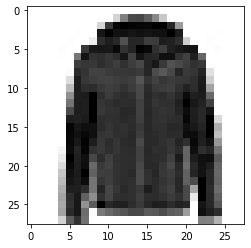

In [8]:
# 数据集都是向量数据, 直接输出无法显示图片, 需要借用matplotlib显示图片
def show_single_image(img_arr):
    # cmp 指的是数据类型
    plt.imshow(img_arr, cmap="binary")
    plt.show()


# 展示图片
show_single_image(x_train[0])

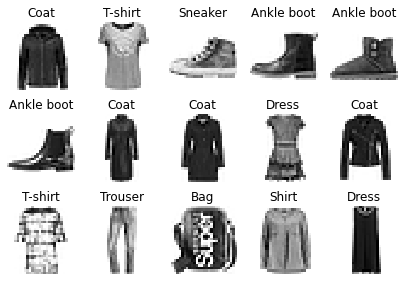

In [9]:
# 展示所有种类的数据
def show_imgs(n_rows, n_cols, x_data, y_data, class_names):
    # 断言, 判断x_data 和 y_data是否相等
    assert len(x_data) == len(y_data)
    assert n_rows * n_cols < len(x_data)

    # 创建画板
    plt.figure(figsize=(n_cols * 1.4, n_rows * 1.6))
    # 展示不同种类的图像
    for row in range(n_rows):
        for col in range(n_cols):
            # 获取索引
            index = n_cols * row + col
            # plt.subplot 用于绘制子图, 参考 : https://www.cnblogs.com/cgmcoding/p/13279406.html
            plt.subplot(n_rows, n_cols, index + 1)
            # interpolation 缩放图片时使用的方法
            plt.imshow(x_data[index], cmap="binary", interpolation="nearest")
            # 关闭坐标系
            plt.axis('off')
            # 设置标题
            plt.title(class_names[y_data[index]])


class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress',
               'Coat', 'Sandal', 'Shirt', 'Sneaker',
               'Bag', 'Ankle boot']
show_imgs(3, 5, x_train, y_train, class_names)

### 3. 模型搭建

- Flatten : 输入层, Flatten 将 多维向量展平为一维向量
- Dense :
    1. 实现操作: output = activation(dot(input, kernel) + bias)
    2. 其中 activation 是作为激活参数传递的逐元素激活函数, kernel 是层创建的权重矩阵, bias 是创建的偏置向量

- 激活函数 :
    1. relu : y = max(0, x)
    2. softmax : 将向量变成概率分布 => x = [x1, x2, x3] -> y = [e^x1 / sum, e^x2 / sum, e^x3 / sum], e^x1 + e^x2 +e^x3 = sum

#### 3.1 搭建深度神经网络

In [10]:
# 创建模型
# model = keras.models.Sequential()
model = keras.models.Sequential()
# 添加输入层, Flatten 将 多维向量展平为一维向量
model.add(keras.layers.Flatten(input_shape=[28, 28]))
# 添加一个20层的深度神经网络
# 使用for 循环添加神经网络
for _ in range(20):
    model.add(keras.layers.Dense(units=64, activation="relu"))

# 添加最终输出层
model.add(keras.layers.Dense(units=10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=['accuracy'])

In [11]:
# 查看模型的层数
model.layers

In [12]:
# 展示模型的架构, 以及可训练参数
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_4 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4

- 全连接层参数计算
- [None, 784] * W + b(偏置) -> [None, 300] => W (参数) shape = [784, 300], b = [300] => 784 * 300 + 300 = 235500

#### 3.2 添加回调函数

- TensorBord : 查看模型训练期间的参数以及计算图
    1. tensorboard --logdir=./tf_keras_code/callbacks 可以查看TensorBoard网页
- Earlystopping : 设置终止训练的条件
- ModelCheckpoint : 保存模型

In [13]:
# 训练模型
# epochs : 训练轮数, validation_data : 验证集, 类型为 tuple(x_valid, y_valid)
# 返回值是训练过程中运行的一些数据结果

# callback : TensorBord , earlystopping, ModelCheckpoint
logdir = "./callbacks" # callback 输出目录
if not os.path.exists(logdir):
    os.mkdir(logdir)
# 设置模型保存目录
out_put_model_file = os.path.join(logdir , "fashion_mnist_model.H5")

callbacks = [
    keras.callbacks.TensorBoard(logdir), # TensorBoard
    keras.callbacks.ModelCheckpoint(out_put_model_file, save_best_only=True), # 保存准确率最高的模型
    # 达到某种条件自动中断模型训练
    # 1. min_delta 最近两次模型训练准确度的差值, 如果两次训练的差值过小 说明训练没有提升, 可以考虑中断训练
    # 2. patience : n 轮训练没有提升后, 训练会被终止
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3)
]

# 在 Command Prompt Shell 下 :
# 使用命令 : tensorboard --logdir=./tf_keras_code/callbacks 可以查看TensorBoard


history = model.fit(x_train_scaled, y_train, epochs=10,
                    validation_data=(x_valid_scaled, y_valid), callbacks=callbacks)

# print(x_train.shape, y_train.shape)

Epoch 1/10
   1/1719 [..............................] - ETA: 0s - loss: 2.3024 - accuracy: 0.1250WARNING:tensorflow:From G:\software\anaconda3\envs\tf2-course-code\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1717/1719 [============================>.] - ETA: 0s - loss: 2.0118 - accuracy: 0.2201 

In [18]:
type(history)

tensorflow.python.keras.callbacks.History

In [19]:
# GPU 和 CPU 训练的结果有很大不同
history.history

{'loss': [0.23833777010440826,
  0.22910819947719574,
  0.22106070816516876,
  0.21353508532047272,
  0.2062564492225647,
  0.19741645455360413,
  0.19040407240390778,
  0.1850060671567917,
  0.17777884006500244],
 'accuracy': [0.9129636287689209,
  0.9171454310417175,
  0.9203272461891174,
  0.9216181635856628,
  0.9264363646507263,
  0.9282000064849854,
  0.9319818019866943,
  0.9343818426132202,
  0.9363272786140442],
 'val_loss': [0.29064908623695374,
  0.2870146334171295,
  0.3031037449836731,
  0.28191956877708435,
  0.28245416283607483,
  0.2869076430797577,
  0.29035916924476624,
  0.28802943229675293,
  0.29376664757728577],
 'val_accuracy': [0.8888000249862671,
  0.8930000066757202,
  0.890999972820282,
  0.894599974155426,
  0.8948000073432922,
  0.8917999863624573,
  0.8934000134468079,
  0.8921999931335449,
  0.8884000182151794]}

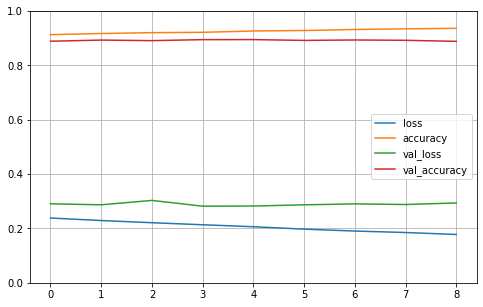

In [20]:
# 绘制图像
def plt_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    # 开启网格
    plt.grid(True)
    # 设置y轴范围
    plt.gca().set_ylim(0, 1)
    # 展示图像
    plt.show()

plt_learning_curves(history)

In [21]:
# 在测试集上评估
model.evaluate(x_test_scaled, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.3409 - accuracy: 0.8816


[0.3409358859062195, 0.881600022315979]